In [ ]:
import pandas as pd
import random as rd
import numpy as np

In [2]:
def separarTreinoTeste(dfA):
    dfB = dfA
    dfC = pd.DataFrame()
    for i in range (len(dfA)):
        vetor = dfA.iloc[i, 0]
        if (rd.random() > 0.8): # vai p teste
            dfB = pd.concat([dfB, pd.DataFrame(data=[[vetor]], columns=['noticias'])], ignore_index=True)
        else:
            dfC = pd.concat([dfC, pd.DataFrame(data=[[vetor]], columns=['noticias'])], ignore_index=True)

    return dfB, dfC

In [3]:
def prepararDfTeste (dfA, dfB):
    # embaralha os dfs
    dfEmbaralhado = pd.concat([dfA, dfB], ignore_index=True)
    indices = list(dfEmbaralhado.index)
    rd.shuffle(indices)
    
    tags = []
    noticias = []

    # cria uma coluna pra tag
    for i in indices:
        news = dfEmbaralhado.iloc[i, 0]
        tags.append(news[0])
        noticias.append(news[1:])

    return pd.DataFrame({'tag': tags, 'noticia': noticias})

In [4]:
def prepararDfsTreino (dfF, dfR):
    # Falsas
    palavrasFalsas = []
    for i in range(len(dfF)):
        noticia = dfF.iloc[i,0][1:]
        palavrasFalsas.extend(noticia)
    dfF = pd.DataFrame({'palavras': palavrasFalsas})
    dfF = dfF.groupby('palavras').size().reset_index(name='aparicoesFalsas')

    palavrasFalsas = []
    for i in range(len(dfR)):
        noticia = dfR.iloc[i,0][1:]
        palavrasFalsas.extend(noticia)
    dfR = pd.DataFrame({'palavras': palavrasFalsas})
    dfR = dfR.groupby('palavras').size().reset_index(name='aparicoesReais')
    palavras = []

    return dfF, dfR

In [5]:
def evaluate(dfReal, dfFalso, noticiasTeste, limiar, coeficiente):
    # Junta os dataframes e une as palavras
    dfJunto = dfReal.merge(dfFalso, how='outer')

    # Conta quantas palavras tem em uma e não tem na outra
    nReal = dfJunto.loc[dfJunto['aparicoesReais'].isna(), 'palavras'].count()
    nFalsa = dfJunto.loc[dfJunto['aparicoesFalsas'].isna(), 'palavras'].count()

    # Preenche as palavras que não aparecem com 1
    dfJunto.fillna(1, inplace=True)

    # Soma as palavras com 0 aparições com 1 para evitar multiplicação por 0
    dfJunto.loc[dfJunto['aparicoesReais'] > 1, 'aparicoesReais'] += 1
    dfJunto.loc[dfJunto['aparicoesFalsas'] > 1, 'aparicoesFalsas'] += 1

    # Remove linhas onde a coluna 'palavras' é vazia ou só espaço
    dfJunto = dfJunto[dfJunto['palavras'].str.strip() != '']

    # Mantém só palavras que têm pelo menos uma letra (a–z ou A–Z ou acentuadas)
    dfJunto = dfJunto[dfJunto['palavras'].str.match(r'^[A-Za-zÀ-ÖØ-öø-ÿ]+$', na=False)]

    # Soma o total de aparições
    totalReal = dfJunto['aparicoesReais'].sum()
    totalFalso = dfJunto['aparicoesFalsas'].sum()

    # Balanceia a ordem de grandeza das aparições
    dfJunto['aparicoesFalsas'] *= totalReal / totalFalso
    
    # Faz o coeficiente de generalized jaccard
    dfJunto['gj'] = np.minimum(dfJunto['aparicoesReais'], dfJunto['aparicoesFalsas']) / np.maximum(dfJunto['aparicoesReais'], dfJunto['aparicoesFalsas'])

    # Faz o coeficiente de bray curtis
    dfJunto['bc'] = abs(dfJunto['aparicoesReais'] - dfJunto['aparicoesFalsas']) / (dfJunto['aparicoesReais'] + dfJunto['aparicoesFalsas'])

    # Limpa palavras com coeficiente menor que o limiar (palavras com aparições equivalentes em ambos casos)
    if (coeficiente == 'bc'):
        dfJunto = dfJunto.loc[dfJunto['bc'] > limiar]
    elif (coeficiente == 'gj'):
        dfJunto = dfJunto.loc[dfJunto['gj'] > limiar]

    # Pega o total de aparições após NLP
    tFalsas = dfJunto['aparicoesFalsas'].sum()
    tReais = dfJunto['aparicoesReais'].sum()

    # Define um df de teste
    dfJuntoTeste = dfJunto

    # Faz os calculos das probabilidades
    dfJuntoTeste['aparicoesFalsas'] = dfJunto['aparicoesFalsas'] / (nFalsa + tFalsas)
    dfJuntoTeste['aparicoesReais'] = dfJunto['aparicoesReais'] / (nReal + tReais)

    # Pega o log na base 10
    dfJuntoTeste['aparicoesFalsas'] = np.log10(dfJuntoTeste['aparicoesFalsas'])
    dfJuntoTeste['aparicoesReais'] = np.log10(dfJuntoTeste['aparicoesReais'])

    # NOTICIA:
    
    indices = ['fF', 'fR', 'rF', 'rR']
    dfDados = pd.DataFrame(0, index=indices, columns=['num'])

    for i in range (len(noticiasTeste)):
        noticia = noticiasTeste.iloc[i, 1]
        tag = noticiasTeste.iloc[i, 0]

        # Cria um df com a notícia limpa
        dfNoticia = pd.DataFrame(data = noticia, columns=['palavra'])

        # Junta o df da noticia com o das probabilidades
        dfNoticia = dfNoticia.merge(dfJuntoTeste, how='inner', left_on='palavra', right_on='palavras')

        # Faz a soma das probabilidades
        iFalsa = dfNoticia['aparicoesFalsas'].sum()
        iReal = dfNoticia['aparicoesReais'].sum()

        # Confere o resultado
        if (iFalsa > iReal): # Falsa
            resultado = 'F'
        elif (iReal == iFalsa): # Empate
            if (tag == 'f'):
                resultado = 'R'
            elif (tag == 'r'):
                resultado = 'F'
        else:
            resultado = 'R'
            
        chave = tag + resultado
        try:
            dfDados.loc[chave, 'num'] += 1
        except:
            pass

    return dfDados

In [ ]:
# Bray curtis
dfFalsoTreino = pd.read_json('../../data/train/fakeTrain.json', orient='records', lines=True)
dfRealTreino = pd.read_json('../../data/train/realTrain.json', orient='records', lines=True)

dfFalsoTeste = pd.read_json('../../data/test/fakeTest.json', orient='records', lines=True) 
dfRealTeste = pd.read_json('../../data/test/realTest.json', orient='records', lines=True) 

dfTestes = prepararDfTeste(dfFalsoTeste, dfRealTeste)

[dfFalsoTreino, dfRealTreino] = prepararDfsTreino(dfFalsoTreino, dfRealTreino)

matrizesDeConfusao = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]
matrizesRounds = []

for i in range(1, 10): 
    limiar = i/10
    matrizDeConfusao = evaluate(dfRealTreino, dfFalsoTreino, dfTestes, limiar, 'bc')
    matrizesRounds.append(matrizDeConfusao)

matrizesDeConfusao.append(matrizesRounds)

acuracidadesBC = []
precisoesReaisBC = []
precisoesFalsasBC = []
sensibilidadeReaisBC = []
sensibilidadeFalsasBC = []
f1ReaisBC = []
f1FalsasBC = []
    
for i in range(0, 9):
    for j in range(1, len(matrizesDeConfusao)):
        acuracidade = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['fF', 'num']) /
            sum(matrizesDeConfusao[j][i]['num'])
        ), 4)
        acuracidadesBC.append(acuracidade)

        precReal = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num']) /
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['fR', 'num'])
        ), 4)
        precisoesReaisBC.append(precReal)

        precFalsa = round(float(
            (matrizesDeConfusao[j][i].loc['fF', 'num']) /
            (matrizesDeConfusao[j][i].loc['fF', 'num'] + matrizesDeConfusao[j][i].loc['rF', 'num'])
        ), 4)
        precisoesFalsasBC.append(precFalsa)

        sensReal = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num']) /
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['rF', 'num'])
        ), 4)
        sensibilidadeReaisBC.append(sensReal)

        sensFalsa = round(float(
            (matrizesDeConfusao[j][i].loc['fF', 'num']) /
            (matrizesDeConfusao[j][i].loc['fF', 'num'] + matrizesDeConfusao[j][i].loc['fR', 'num'])
        ), 4)
        sensibilidadeFalsasBC.append(sensFalsa)

        f1Real = round(2 * ((precReal * sensReal) / (precReal + sensReal)), 4)
        f1ReaisBC.append(f1Real)

        f1Falsa = round(2 * ((precFalsa * sensFalsa) / (precFalsa + sensFalsa)), 4)
        f1FalsasBC.append(f1Falsa)

In [ ]:
# Generalized Jaccard
dfFalsoTreino = pd.read_json('../../data/train/fakeTrain.json', orient='records', lines=True)
dfRealTreino = pd.read_json('../../data/train/realTrain.json', orient='records', lines=True)

dfFalsoTeste = pd.read_json('../../data/test/fakeTest.json', orient='records', lines=True) 
dfRealTeste = pd.read_json('../../data/test/realTest.json', orient='records', lines=True) 

dfTestes = prepararDfTeste(dfFalsoTeste, dfRealTeste)

[dfFalsoTreino, dfRealTreino] = prepararDfsTreino(dfFalsoTreino, dfRealTreino)

matrizesDeConfusao = [[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]]
matrizesRounds = []

for i in range(1, 10): 
    limiar = i/10
    matrizDeConfusao = evaluate(dfRealTreino, dfFalsoTreino, dfTestes, limiar, 'gj')
    matrizesRounds.append(matrizDeConfusao)

matrizesDeConfusao.append(matrizesRounds)
acuracidadesGJ = []
precisoesReaisGJ = []
precisoesFalsasGJ = []
sensibilidadeReaisGJ = []
sensibilidadeFalsasGJ = []
f1ReaisGJ = []
f1FalsasGJ = []

for i in range(0, 9):
    for j in range(1, len(matrizesDeConfusao)):
        acuracidade = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['fF', 'num']) /
            sum(matrizesDeConfusao[j][i]['num'])
        ), 4)
        acuracidadesGJ.append(acuracidade)

        precReal = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num']) /
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['fR', 'num'])
        ), 4)
        precisoesReaisGJ.append(precReal)

        precFalsa = round(float(
            (matrizesDeConfusao[j][i].loc['fF', 'num']) /
            (matrizesDeConfusao[j][i].loc['fF', 'num'] + matrizesDeConfusao[j][i].loc['rF', 'num'])
        ), 4)
        precisoesFalsasGJ.append(precFalsa)

        sensReal = round(float(
            (matrizesDeConfusao[j][i].loc['rR', 'num']) /
            (matrizesDeConfusao[j][i].loc['rR', 'num'] + matrizesDeConfusao[j][i].loc['rF', 'num'])
        ), 4)
        sensibilidadeReaisGJ.append(sensReal)

        sensFalsa = round(float(
            (matrizesDeConfusao[j][i].loc['fF', 'num']) /
            (matrizesDeConfusao[j][i].loc['fF', 'num'] + matrizesDeConfusao[j][i].loc['fR', 'num'])
        ), 4)
        sensibilidadeFalsasGJ.append(sensFalsa)

        f1Real = round(2 * ((precReal * sensReal) / (precReal + sensReal)), 4)
        f1ReaisGJ.append(f1Real)

        if (precFalsa + sensFalsa) == 0:
            f1Falsa = 0
        else:
            f1Falsa = round(2 * ((precFalsa * sensFalsa) / (precFalsa + sensFalsa)), 4)
        f1FalsasGJ.append(f1Falsa)

In [115]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import EventCollection


def criarGrafico(ybc, ygj, titulo):
    xdata = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
    # plot the data
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(xdata, ygj, color='tab:blue') # Jaccard
    ax.plot(xdata, ybc, color='tab:orange') # Bray Curtis

    # create the events marking the x data points
    xevents1 = EventCollection(xdata, color='tab:blue', linelength=0.05) 
    xevents2 = EventCollection(xdata, color='tab:orange', linelength=0.05)

    # create the events marking the y data points
    yevents1 = EventCollection(acuracidadesGJ, color='tab:blue', linelength=0.05,
                            orientation='vertical')
    yevents2 = EventCollection(acuracidadesBC, color='tab:orange', linelength=0.05,
                            orientation='vertical')


    # set the limits
    #ax.set_xlim([0, 1])
    #ax.set_ylim([0, 1])

    ax.set_title(titulo)

    # display the plot
    plt.show()

In [ ]:
acuracidadeGrafico = criarGrafico(acuracidadesBC, acuracidadesGJ, 'Acurácia')
precisaoFalsaGrafico = criarGrafico(precisoesFalsasBC, precisoesFalsasGJ, 'Precisão Falsa')
precisaoRealGrafico = criarGrafico(precisoesReaisBC, precisoesReaisGJ, 'Precisão Real')
sensibilidadeFalsaGrafico = criarGrafico(sensibilidadeFalsasBC, sensibilidadeFalsasGJ, 'Sensibilidade Falsa')
sensibilidadeRealGrafico = criarGrafico(sensibilidadeReaisBC, sensibilidadeReaisGJ, 'Sensibilidade Real')
f1FalsaGrafico = criarGrafico(f1FalsasBC, f1FalsasGJ, 'F1 Falsa')
f1RealGrafico = criarGrafico(f1ReaisBC, f1ReaisGJ, 'F1 Real')

In [ ]:
def criarGraficoPlotado(titulo, yfalsasgj, y1falsasbc, yreaisgj, y1reaisbc):
    x = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(12, 6))

    ax0.set_title('Falsas')
    ax0.set_ylabel(titulo)
    ax0.set_xlabel('Limiares')
    ax0.plot(x, yfalsasgj)
    ax0.plot(x, y1falsasbc)

    ax1.set_title('Reais')
    ax1.plot(x, yreaisgj)
    ax1.set_ylabel(titulo)
    ax1.set_xlabel('Limiares')
    ax1.plot(x, y1reaisbc)

    fig.legend('Coeficientes')

    fig.suptitle(f'{titulo} por limiar')
    plt.savefig(f'{titulo}.png')
    plt.show()

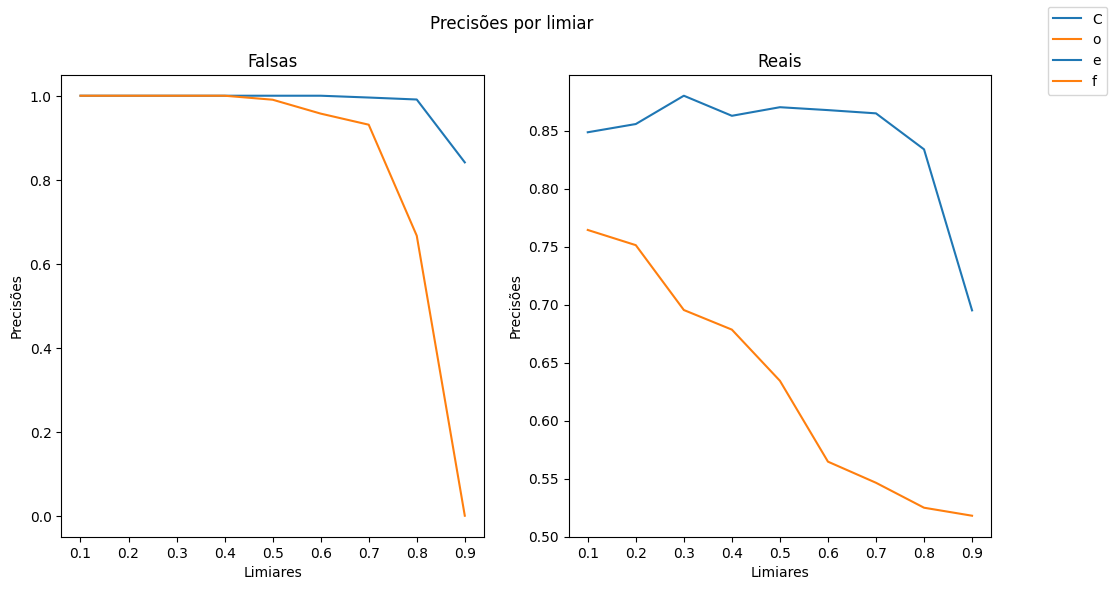

In [120]:
criarGraficoPlotado('Precisões', precisoesFalsasBC, precisoesFalsasGJ, precisoesReaisBC, precisoesReaisGJ)